# Pulse Sequence Diagnostics (Minimal)

This notebook demonstrates three core checks using the refactored pulse system and public APIs:
- Envelope type comparison (cos^2 vs gaussian)
- Spectral comparison of single-pulse envelopes
- Dynamic modification of phases and delays in a 3-pulse sequence

In [1]:
# Minimal imports for this streamlined notebook
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.laser_system.laser_fcts import pulse_envelopes
from qspectro2d.visualization.plotting import plot_pulse_envelopes

from plotstyle import COLORS, LINE_STYLES, init_style
init_style()


custom_dir = Path("test_pulses")
custom_dir.mkdir(exist_ok=True)

# Helper: summed envelope using module function
def envelopes(times: np.ndarray, seq: LaserPulseSequence) -> np.ndarray:
    return pulse_envelopes(times, seq)


def plot_envelopes(times: np.ndarray, seq: LaserPulseSequence, ax=None, label_prefix: str = "env"):
    fig, ax = plot_pulse_envelopes(times, seq, ax=ax, show_legend=True)
    ax.set_title("Summed pulse envelopes")
    return fig, ax

## 1. Envelope Type Comparison

Section 1: Envelope type comparison (cos^2 vs gaussian)


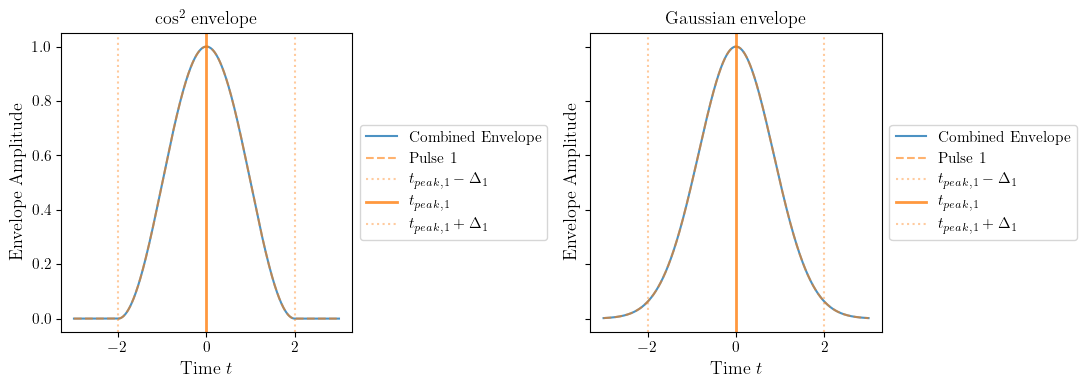

In [2]:
# Envelope Type Comparison using from_pulse_delays
print("Section 1: Envelope type comparison (cos^2 vs gaussian)")

# Parameters
fwhm       = 2.0     # fs (FWHM)
amplitude  = 1.0     # a.u.
carrier_cm = 16000.0 # cm^-1
phase_val  = np.pi/2 # rad

# Build single-pulse sequences via delays (single pulse -> empty delays list)
seq_cos2  = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=amplitude,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=carrier_cm,
    envelope_type="cos2",
    relative_E0s=[1.0],
    phases=[phase_val],
)
seq_gauss = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=amplitude,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=carrier_cm,
    envelope_type="gaussian",
    relative_E0s=[1.0],
    phases=[phase_val],
)

# Manually relocate peak of single pulse to desired t_peak (first pulse defaults to 0 fs)
local_times = np.linspace(- 1.5 * fwhm, + 1.5 * fwhm, 800)

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
plot_envelopes(local_times, seq_cos2, ax=axes[0], label_prefix="cos2")
axes[0].set_title(r"cos$^2$ envelope")
plot_envelopes(local_times, seq_gauss, ax=axes[1], label_prefix="gaussian")
axes[1].set_title(r"Gaussian envelope")
fig.tight_layout()

## 2. Multi-Pulse Gaussian Sequence Diagnostics

Section 2: Multi-pulse gaussian diagnostics (envelope only)
✓ Multi-pulse gaussian diagnostic ready


(<Figure size 800x1000 with 3 Axes>,
 <Axes: title={'center': 'RWA Electric Field Components'}, xlabel='Time $t$', ylabel='Electric Field (RWA)'>)

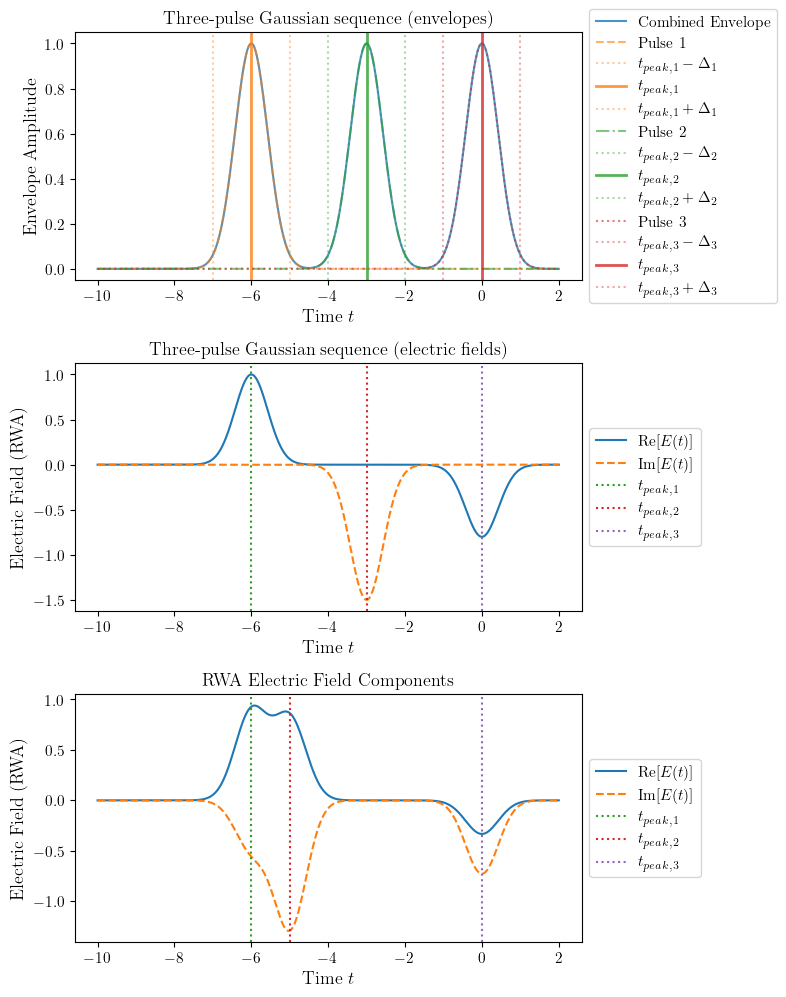

In [3]:
# Multi-Pulse Gaussian Diagnostics (kept minimal)
print("Section 2: Multi-pulse gaussian diagnostics (envelope only)")

times = np.linspace(-10.0, 2.0, 600)

# Build 3-pulse sequence from delays: delays define gaps between consecutive peaks
# Example: peak times at -6.0, -3.0, 0.0 fs -> delays [3.0, 3.0]
seq_multi = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[3.0, 3.0],
    base_amplitude=1.0,
    pulse_fwhm_fs=1.0,
    carrier_freq_cm=10000.0,
    envelope_type="gaussian",
    relative_E0s=[1.0, 1.5, 0.8],
    phases=[0.0, 1.57, 3.14],
)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
plot_envelopes(times, seq_multi, ax=ax1, label_prefix="gaussian")
ax1.set_title(r"Three-pulse Gaussian sequence (envelopes)")
from qspectro2d.visualization.plotting import plot_e_pulses
plot_e_pulses(times, seq_multi, ax=ax2)
ax2.set_title(r"Three-pulse Gaussian sequence (electric fields)")
fig.tight_layout()
print("✓ Multi-pulse gaussian diagnostic ready")
seq_multi.pulse_phases = [0.5, 1.0, 2.0]
seq_multi.pulse_delays = [1.0, 5.0]
ax3.set_title(r"CHANGED PHASES and DELAYS")
plot_e_pulses(times, seq_multi, ax=ax3)

🔧 Configured to use max_workers=12 for parallel tasks.
🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: ME
Time range: t0=-140.000, t_max=100.000, dt=0.100000
Number of time points: 2401
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[2], [2]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Number of decay channels: 2
Applying RWA phase factors: n_atoms=1, omega_laser=3.0139183281479043 [fs^-1]
=== STATE-BY-STATE ANALYSIS ===
✅ Checks passed. DM remains Hermitian and positive.
Final state trace: 1.000000
Final state min eigenvalue: 0.0398062419
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
Section 2: Mu

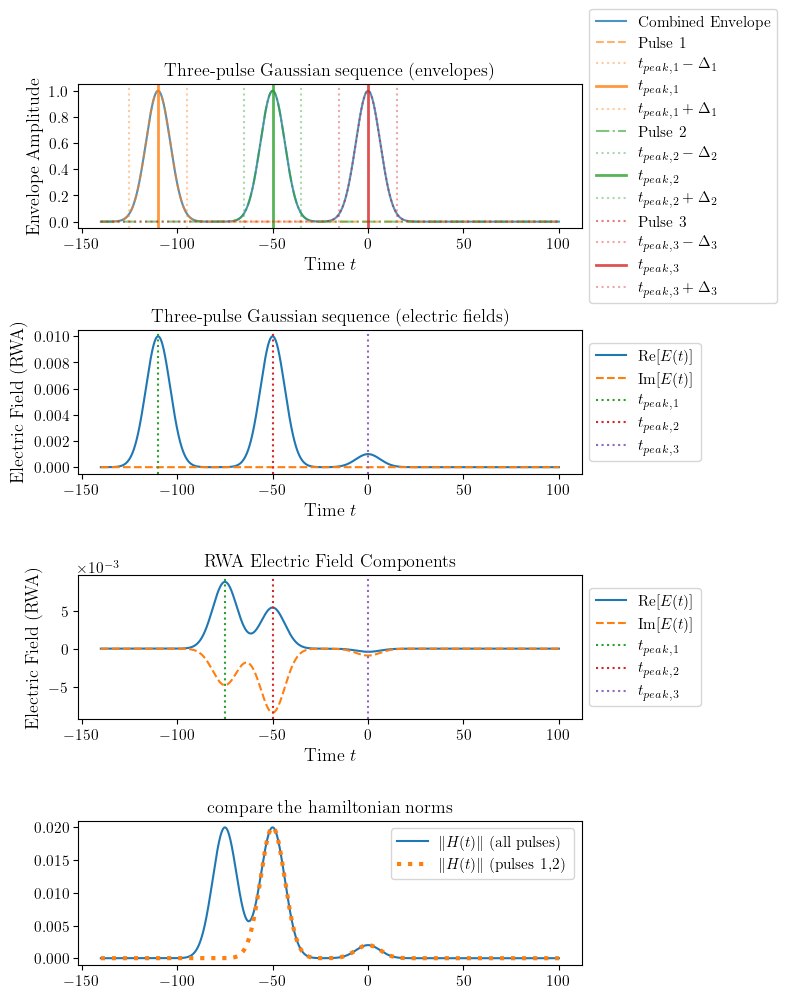

In [4]:
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.spectroscopy.e_field_1d import sim_with_only_pulses
# Build base simulation (applies CLI overrides inside)
from pathlib import Path
NOTEBOOK_DIR = Path.cwd()
for _parent in NOTEBOOK_DIR.parents:
    if (_parent / ".git").is_dir():
        PROJECT_ROOT = _parent
        break
SCRIPTS_DIR = (PROJECT_ROOT / "scripts").resolve()
config_path = SCRIPTS_DIR / "simulation_configs" / "template.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path)
seq_multi = sim_oqs.laser

# Multi-Pulse Gaussian Diagnostics (kept minimal)
print("Section 2: Multi-pulse gaussian diagnostics (envelope only)")

times = sim_oqs.times_local

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10))
plot_envelopes(times, seq_multi, ax=ax1, label_prefix="gaussian")
ax1.set_title(r"Three-pulse Gaussian sequence (envelopes)")
from qspectro2d.visualization.plotting import plot_e_pulses
plot_e_pulses(times, seq_multi, ax=ax2)
ax2.set_title(r"Three-pulse Gaussian sequence (electric fields)")
fig.tight_layout()
print("✓ Multi-pulse gaussian diagnostic ready")
seq_multi.pulse_phases = [0.5, 1.0, 2.0]
new_delays = [times[-1]/4, times[-1]/2]
sim_oqs.update_delays(*new_delays)
seq_multi.pulse_delays = new_delays
print("NEW TIMES ARE: ", seq_multi.pulse_delays)
print("And the Laser has: ", sim_oqs.laser.pulse_delays)
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
print("and the config uses:", t_coh, t_wait)
ax3.set_title(r"CHANGED PHASES and DELAYS")
plot_e_pulses(times, seq_multi, ax=ax3)
norms_all = np.array([sim_oqs.evo_obj(t).norm() for t in times])

sim_i = sim_with_only_pulses(sim_oqs, [1, 2])
norms_only = np.array([sim_i.evo_obj(t).norm() for t in times])
ax4.set_title(r"compare the hamiltonian norms")
ax4.plot(times, norms_all, color=COLORS[0], ls="-", label=r"$\|H(t)\|$ (all pulses)")
ax4.plot(times, norms_only, color=COLORS[1], ls=":", linewidth=3, label=r"$\|H(t)\|$ (pulses 1,2)")
ax4.legend()

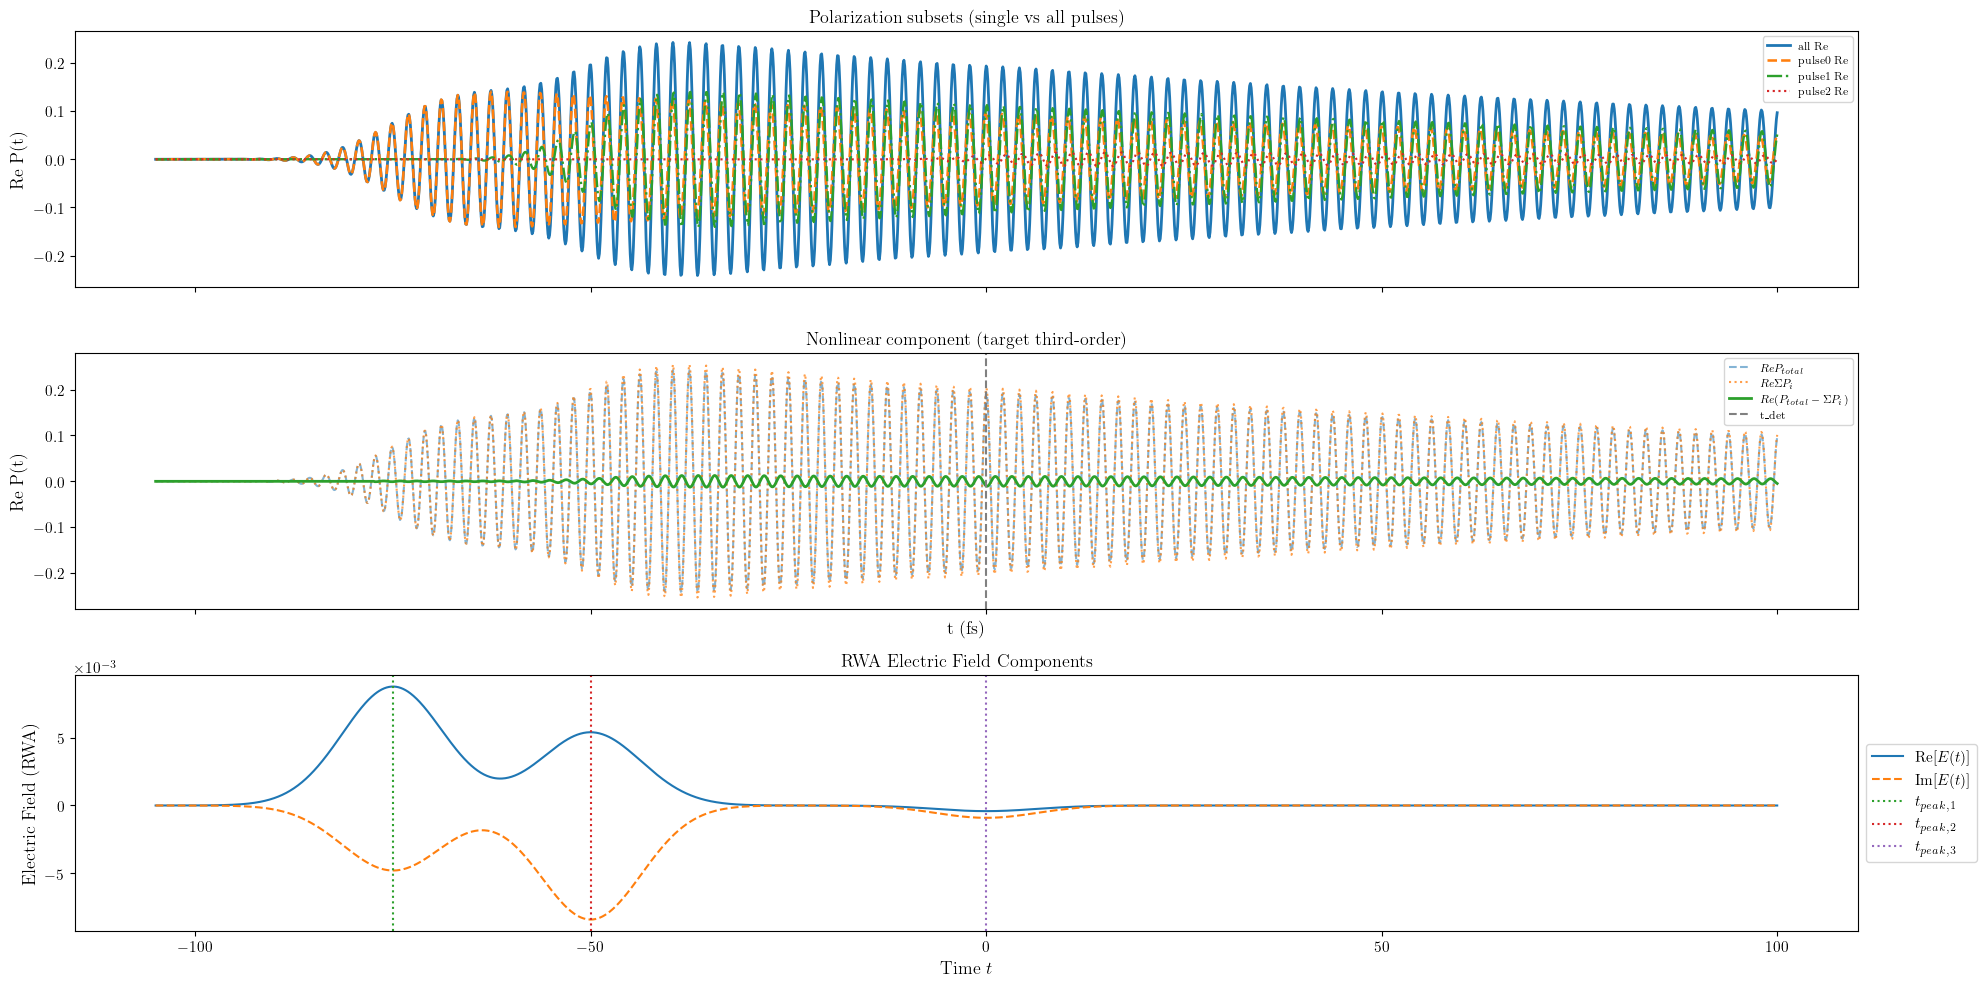

In [5]:
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window
# 2. Evolution subsets: all pulses vs single pulse vs modified amplitude
subset_specs = {
    'all': list(range(len(sim_oqs.laser.pulses))),
}
# Add individual pulses
for i in range(len(sim_oqs.laser.pulses)):
    subset_specs[f'pulse{i}'] = [i]

pol_datas = {}
base_window = sim_oqs.times_local  # detection / plotting window (assumed uniform grid)

for label, idxs in subset_specs.items():
    sim_sub = sim_with_only_pulses(sim_oqs, idxs) if label != 'all' else sim_oqs
    t_actual, P = compute_polarization_over_window(sim_sub, base_window)
    pol_datas[label] = P

# Build nonlinear component: P_total - Σ_i P_i
P_total = pol_datas['all']
linear_sum = np.zeros_like(P_total, dtype=complex)
for i in range(len(sim_oqs.laser.pulses)):
    linear_sum += pol_datas[f'pulse{i}']
pol_nonlinear = P_total - linear_sum  # store for later reuse if needed

# Plotting: two subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(20,10), sharex=True)
ax1, ax2, ax3 = axes

# Subplot 1: original subset comparison (real part)
for idx, (k, v) in enumerate(pol_datas.items()):
    ax1.plot(t_actual, np.real(v), color=COLORS[idx % len(COLORS)], linewidth=2-0.15*idx, label=f'{k} Re')
ax1.set_ylabel('Re P(t)')
ax1.set_title('Polarization subsets (single vs all pulses)')
ax1.legend(loc='best', fontsize=8)

# Subplot 2: nonlinear component extraction
ax2.plot(t_actual, np.real(P_total), label='$Re P_{total}$', linestyle='--', color=COLORS[0], alpha=0.55)
ax2.plot(t_actual, np.real(linear_sum), label='$Re \Sigma P_i$', linestyle=':', color=COLORS[1], alpha=0.75)
ax2.plot(t_actual, np.real(pol_nonlinear), label='$Re (P_{total} - \Sigma P_i)$', color=COLORS[2], linewidth=2.0)
ax2.axvline(x=sim_oqs.t_det[0], color='gray', linestyle='--', label='t_det')
ax2.set_ylabel('Re P(t)')
ax2.set_xlabel('t (fs)')
ax2.set_title('Nonlinear component (target third-order)')
ax2.legend(loc='best', fontsize=8)
if sim_oqs.simulation_config.rwa_sl:
    plot_e_pulses(t_actual, sim_oqs.laser, ax=ax3)
else:
    plot_e_pulses(t_actual, sim_oqs.laser, ax=ax3)
plt.tight_layout()
plt.show()

## 2. Spectral Envelope Comparison

Section 3: Spectral comparison of envelope shapes
✓ Spectral comparison ready


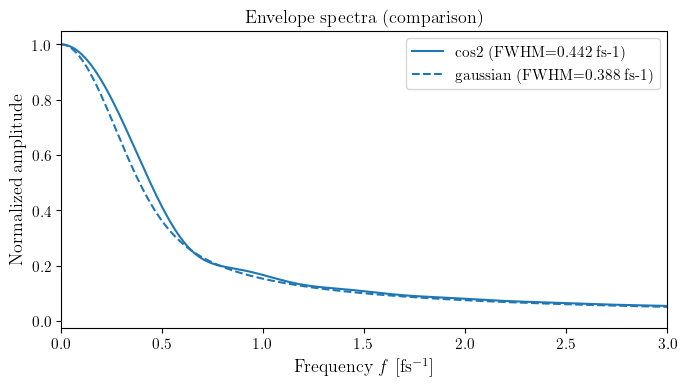

In [6]:
# Spectral comparison (FFT of envelopes)
print("Section 3: Spectral comparison of envelope shapes")

def spectral_envelope(times: np.ndarray, seq: LaserPulseSequence):
    env = envelopes(times, seq)
    N   = len(times)
    dt  = times[1] - times[0]
    N_fft = 1 << (N - 1).bit_length()  # next power of two
    spec = np.fft.fft(env, n=N_fft)
    freq = np.fft.fftfreq(N_fft, dt)
    pos  = freq >= 0
    mag  = np.abs(spec[pos])
    if mag.max() > 0:
        mag = mag / mag.max()
    # FWHM estimate
    idx = np.where(mag >= 0.5)[0]
    fwhm_freq = (freq[pos][idx[-1]] - freq[pos][idx[0]]) if len(idx) > 1 else 0.0
    return freq[pos], mag, fwhm_freq

DT     = 0.05  # fs
T_MAX  = 300.0 # fs
spec_t = np.arange(0.0, T_MAX, DT)

# Build fresh single-pulse sequences at t=0 for spectral analysis
seq_cos2_spec  = LaserPulseSequence.from_pulse_delays([], amplitude, fwhm, carrier_cm, "cos2", [1.0], [phase_val])
seq_gauss_spec = LaserPulseSequence.from_pulse_delays([], amplitude, fwhm, carrier_cm, "gaussian", [1.0], [phase_val])

f_cos, mag_cos, fwhm_cos = spectral_envelope(spec_t, seq_cos2_spec)
f_gau, mag_gau, fwhm_gau = spectral_envelope(spec_t, seq_gauss_spec)

figs, axs = plt.subplots(1, 1, figsize=(7, 4))
axs.plot(f_cos, mag_cos, label=f"cos2 (FWHM={fwhm_cos:.3f} fs-1)")
axs.plot(f_gau, mag_gau, label=f"gaussian (FWHM={fwhm_gau:.3f} fs-1)")
axs.set_xlim(0, 3.0)
axs.set_xlabel(r"Frequency $f$ [fs$^{-1}$]")
axs.set_ylabel("Normalized amplitude")
axs.set_title("Envelope spectra (comparison)")
axs.legend()
figs.tight_layout()
print("✓ Spectral comparison ready")

## 4. Advanced Plotting Demonstrations

Section 4: Dynamic modification of phases and delays
✓ Dynamic updates applied


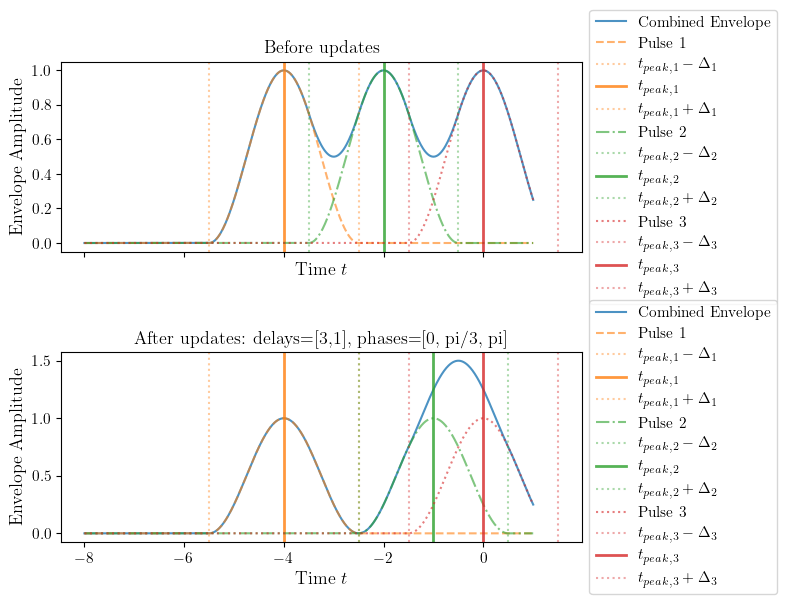

In [7]:
# Dynamic modification: phases and delays
print("Section 4: Dynamic modification of phases and delays")

# Start from a simple 3-pulse cos2 sequence with equal delays
seq_dyn = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[2.0, 2.0],
    base_amplitude=1.0,
    pulse_fwhm_fs=1.5,
    carrier_freq_cm=12000.0,
    envelope_type="cos2",
    relative_E0s=[1.0, 1.0, 1.0],
    phases=[0.0, 0.0, 0.0],
)

t_axis = np.linspace(-8.0, 1.0, 600)
fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plot_envelopes(t_axis, seq_dyn, ax=ax3a, label_prefix="before")
ax3a.set_title("Before updates")

# Update: change delays and phases dynamically
seq_dyn.pulse_delays = [3.0, 1.0]          # setter should recompute peak times
seq_dyn.pulse_phases = [0.0, np.pi/3, np.pi]
plot_envelopes(t_axis, seq_dyn, ax=ax3b, label_prefix="after")
ax3b.set_title("After updates: delays=[3,1], phases=[0, pi/3, pi]")
fig3.tight_layout()
print("✓ Dynamic updates applied")

In [8]:
# Ultrashort Pulse Limit in Qubit-Laser Interaction

##In the ultrashort pulse limit, where the pulse duration (FWHM = 0.05 fs) is much shorter than the system's characteristic time scales (e.g., Rabi period), the interaction approximates an instantaneous perturbation. For a resonant π-pulse (amplitude ≈ π), the qubit undergoes a complete population inversion from |0⟩ to |1⟩, as seen in the Bloch trajectory evolving to the south pole and remaining there post-pulse. This limit simplifies dynamics to impulsive kicks, neglecting oscillatory behavior during the pulse.

In [9]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import epsilon_pulses  # Use workspace pulse functions
from qspectro2d.visualization.plotting import plot_epsilon_pulses
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence

def plot_bloch_trajectories(
    states_list,
    labels=None,
    colors=None,
    linestyles=None,
    elev=15,
    azim=-45,
    offset=2.25,
    xy_offset_factor=0.6,
    proj_alpha=0.7,
    sphere_alpha=0.1,
    skip_density=200,
    fig_size=(10, 9),
):
    """Plot multiple Bloch trajectories on a single Bloch sphere with projections onto
    the three orthogonal planes.

    Parameters
    - states_list: list of list-of-states (each inner list is a time-ordered sequence of Qobj states)
    - labels: list of labels for each trajectory
    - colors: list of color strings
    - linestyles: list of linestyles
    - elev, azim: view angles
    - offset: distance of the side planes from the origin
    - xy_offset_factor: multiplier for the x-y plane offset (so it can be closer)
    - proj_alpha: alpha for projection lines/scatter
    - sphere_alpha: alpha for the Bloch sphere surface
    - skip_density: approximate number of points to display (controls subsampling)
    - fig_size: figure size tuple

    Returns (fig, ax)
    """
    sx = qt.sigmax()
    sy = qt.sigmay()
    sz = qt.sigmaz()

    # default labels/colors/linestyles
    n = len(states_list)
    if labels is None:
        labels = [f"Traj {i+1}" for i in range(n)]
    if colors is None:
        default_colors = [
            "tab:blue",
            "tab:green",
            "tab:orange",
            "tab:red",
            "tab:purple",
        ]
        colors = [default_colors[i % len(default_colors)] for i in range(n)]
    if linestyles is None:
        linestyles = ["-"] * n

    # compute Bloch vectors for each states list
    all_bvs = []
    for states in states_list:
        bv = np.real(
            np.array(
                [[qt.expect(sx, s), qt.expect(sy, s), qt.expect(sz, s)] for s in states]
            )
        )
        all_bvs.append(bv)

    # plotting
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection="3d")

    # draw Bloch sphere with QuTiP helper
    b = qt.Bloch(fig=fig, axes=ax)
    b.render()

    # set sphere alpha (try to only affect polygon/collection artists)
    for coll in list(ax.collections):
        try:
            coll.set_alpha(sphere_alpha)
        except Exception:
            pass

    def bv_to_xyz(bv):
        bv = np.asarray(bv)
        x = -bv[:, 1]
        y = bv[:, 0]
        z = bv[:, 2]
        return x, y, z

    # set view
    ax.view_init(elev=elev, azim=azim)
    az = np.deg2rad(azim)
    el = np.deg2rad(elev)
    cam_dir = np.array([np.cos(el) * np.cos(az), np.cos(el) * np.sin(az), np.sin(el)])

    # compute plane offsets (x-y plane may be closer)
    z_plane = -np.sign(cam_dir[2]) * offset * xy_offset_factor
    x_plane = -np.sign(cam_dir[0]) * offset
    y_plane = -np.sign(cam_dir[1]) * offset

    # projection sampling
    skip = max(1, int(len(all_bvs[0]) / skip_density)) if len(all_bvs[0]) > 0 else 1

    main_handles = []
    for bv, color, ls, label in zip(all_bvs, colors, linestyles, labels):
        x, y, z = bv_to_xyz(bv)
        # main trajectory
        line = ax.plot(x, y, z, color=color, linestyle=ls, linewidth=2, label=label)[0]
        main_handles.append(line)

        # projections (x-y on z_plane)
        ax.plot(
            x,
            y,
            np.full_like(x, z_plane),
            color=color,
            linestyle=ls,
            alpha=proj_alpha,
            linewidth=1,
        )
        ax.scatter(
            x[::skip],
            y[::skip],
            np.full_like(x[::skip], z_plane),
            color=color,
            alpha=proj_alpha,
            s=6,
        )

        # x-z on fixed y plane
        ax.plot(
            x,
            np.full_like(x, y_plane),
            z,
            color=color,
            linestyle=ls,
            alpha=proj_alpha,
            linewidth=1,
        )
        ax.scatter(
            x[::skip],
            np.full_like(x[::skip], y_plane),
            z[::skip],
            color=color,
            alpha=proj_alpha,
            s=6,
        )

        # y-z on fixed x plane
        ax.plot(
            np.full_like(y, x_plane),
            y,
            z,
            color=color,
            linestyle=ls,
            alpha=proj_alpha,
            linewidth=1,
        )
        ax.scatter(
            np.full_like(y[::skip], x_plane),
            y[::skip],
            z[::skip],
            color=color,
            alpha=proj_alpha,
            s=6,
        )

        # start markers
        if len(x) > 0:
            ax.scatter(x[0], y[0], z[0], color=color, s=36)
            ax.scatter(x[0], y[0], z_plane, color=color, s=12, alpha=0.9)

    # draw projected circle borders (unit circles in plotting coords)
    T = np.linspace(0, 2 * np.pi, 300)
    cx = np.cos(T)
    cy = np.sin(T)
    ax.plot(
        cx,
        cy,
        np.full_like(cx, z_plane),
        color="gray",
        linewidth=1.25,
        alpha=proj_alpha,
    )
    ax.plot(
        cx,
        np.full_like(cx, y_plane),
        np.sin(T),
        color="gray",
        linewidth=1.25,
        alpha=proj_alpha,
    )
    ax.plot(
        np.full_like(cx, x_plane),
        cx,
        np.sin(T),
        color="gray",
        linewidth=1.25,
        alpha=proj_alpha,
    )

    # appearance
    ax.set_xlim(-1.3, 1.5)
    ax.set_ylim(-1.3, 1.5)
    ax.set_zlim(-1.3, 1.3)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    # legend only for main trajectories
    ax.legend(handles=main_handles, loc="upper left", bbox_to_anchor=(0.01, 0.98))
    plt.tight_layout()

    return fig, ax


C:\Users\leopo\AppData\Local\Temp\ipykernel_4300\1313872954.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_env = np.trapz(field, times)
C:\Users\leopo\AppData\Local\Temp\ipykernel_4300\1313872954.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Theta_check = np.trapz(Omega_t, times)                # should be 2π


Pulse area Θ = 6.283185+0.000000j (target 2π = 6.283185)
Final excited-state population P(|1>) = 0.000000


c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


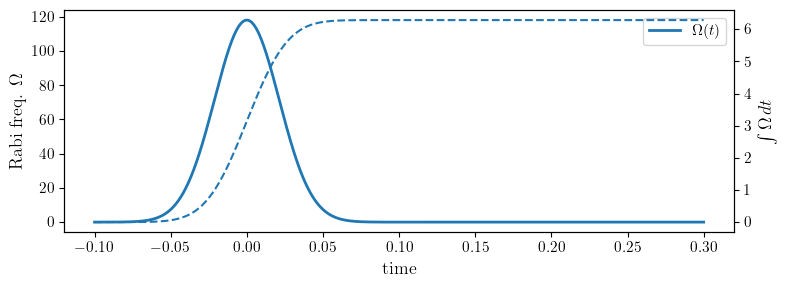

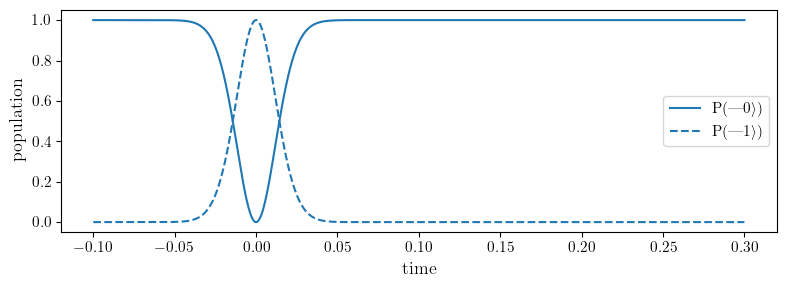

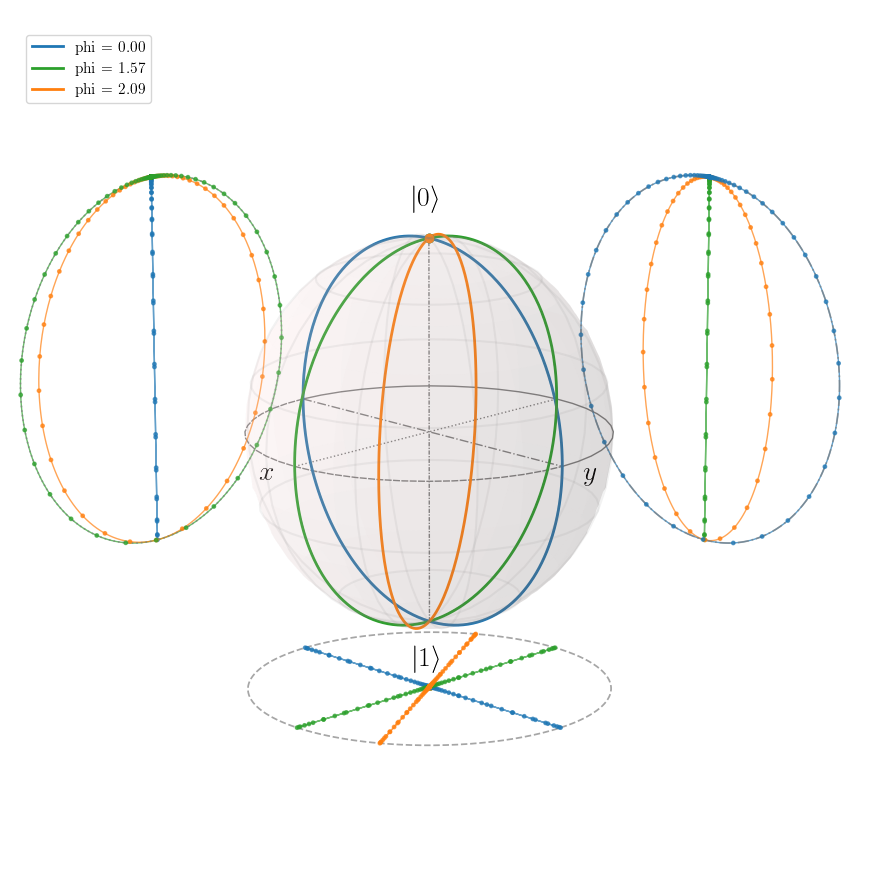

In [10]:
# -*- coding: utf-8 -*-
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import epsilon_pulses, pulse_envelopes  # Use workspace pulse functions
from qspectro2d.visualization.plotting import plot_epsilon_pulses
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence

# ---------- helpers ----------
def rotation_axis(phi):
    """Return the Pauli operator for axis (cosφ σx + sinφ σy)."""
    return np.cos(phi) * qt.sigmax() + np.sin(phi) * qt.sigmay()

def pop_excited(state):
    """Population in |1>."""
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    return qt.expect(P1, state)

# ---------- parameters ----------
# Time axis (arbitrary units; fs, ns...just be consistent)
fwhm = 0.05
t0   = 0.0
t_left, t_right = -2.0 * fwhm, 6.0 * fwhm
N = 1200
times = np.linspace(t_left, t_right, N)

# Create the pulse sequence using workspace functions
seq = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=1.0,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=0.0,  # no carrier for envelope-only
    envelope_type="gaussian",
    relative_E0s=[1.0],
    phases=[0.0],
)

# Get envelope and compute scaling for pi pulse
field = epsilon_pulses(times, seq)
area_env = np.trapz(field, times)
scaling = 2 * np.pi / area_env  # scaling factor for pi pulse

# Phase selects rotation axis: 0 → x, np.pi/2 → y
phi_values = [0.0, np.pi/2, 2*np.pi/3]
all_states = []

for phi in phi_values:
    # ---------- build Ω(t) with Θ = 2π (for pi pulse) ----------
    Omega_t = scaling * field
    Theta_check = np.trapz(Omega_t, times)                # should be 2π

    # ---------- Hamiltonian ----------
    H_axis = rotation_axis(phi)         # cosφ σx + sinφ σy
    H_td = [0.5 * H_axis, Omega_t]      # ½ σ_axis * Ω(t)  (ħ=1 units)

    # ---------- initial state and evolution ----------
    psi0 = qt.basis(2, 0)               # |0>
    result = qt.mesolve(H_td, psi0, times, options={"store_states": True})
    states = result.states
    all_states.append(states)

# ---------- diagnostics (for last phi) ----------
p1_final = pop_excited(states[-1])          # should be ~1 for φ=0 (x-π pulse)
print(f"Pulse area Θ = {Theta_check:.6f} (target 2π = {2*np.pi:.6f})")
print(f"Final excited-state population P(|1>) = {p1_final:.6f}")

# ---------- plots ----------
# 1) Rabi frequency and its area
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, Omega_t, lw=2, label=r'$\Omega(t)$')
ax.set_xlabel("time")
ax.set_ylabel(r'Rabi freq. $\Omega$')
ax.legend()
ax2 = ax.twinx()
ax2.plot(times, np.cumsum(np.concatenate([[0], 0.5*(Omega_t[1:]+Omega_t[:-1]) * np.diff(times)])),
         ls="--", label="cumulative area")
ax2.set_ylabel(r"$\int \Omega \, dt$")
fig.tight_layout()
plt.show()

# 2) Populations
P0 = [1 - pop_excited(s) for s in states]
P1 = [pop_excited(s) for s in states]
plt.figure(figsize=(8,3))
plt.plot(times, P0, label="P(|0⟩)")
plt.plot(times, P1, label="P(|1⟩)")
plt.xlabel("time")
plt.ylabel("population")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Bloch trajectory
labels = [f"phi = {phi:.2f}" for phi in phi_values]
plot_bloch_trajectories(all_states, labels=labels)

plt.show()

In [11]:
# -*- coding: utf-8 -*-
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import epsilon_pulses, pulse_envelopes  # Use workspace pulse functions
from qspectro2d.visualization.plotting import plot_epsilon_pulses
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.atomic_system import AtomicSystem
from qspectro2d.config import load_simulation

# ---------- helpers ----------
def pop_excited(state):
    """Population in |1>."""
    P1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    return qt.expect(P1, state)

# ---------- parameters ----------
# Time axis (arbitrary units; fs, ns...just be consistent)
fwhm = 0.05
t0   = 0.0
t_left, t_right = -2.0 * fwhm, 6.0 * fwhm
N = 1200
times = np.linspace(t_left, t_right, N)

# Create the pulse sequence using workspace functions
seq = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=np.pi,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=0.0,  # no carrier for envelope-only
    envelope_type="gaussian",
    relative_E0s=[1.0],
    phases=[0.0],
)
sys = AtomicSystem()

sim_oqs = load_simulation()
print(sim_oqs)
sim_oqs.atomic_system = sys
sim_oqs.laser = seq

🔧 Configured to use max_workers=12 for parallel tasks.
SimulationModuleOQS(simulation_config=SimulationConfig(ode_solver='BR', solver_options={}, rwa_sl=True, dt=0.1, t_coh=0.0, t_wait=0.0, t_det_max=20.0, sim_type='1d', n_inhomogen=1, n_phases=4, inhom_averaged=False, max_workers=12, signal_types=['rephasing']), system=AtomicSystem(n_atoms=1, n_chains=1, frequencies_cm=[16000.0], dip_moments=[1.0], coupling_cm=0.0, delta_inhomogen_cm=0.0, max_excitation=1, psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]), laser=LaserPulseSequence(pulses=[LaserPulse(pulse_index=0, pulse_peak_time=np.float64(0.0), pulse_phase=0.0, pulse_fwhm_fs=15.0, pulse_amplitude=0.01, pulse_freq_cm=16000.0, envelope_type='gaussian'), LaserPulse(pulse_index=1, pulse_peak_time=np.float64(0.0), pulse_phase=0.0, pulse_fwhm_fs=15.0, pulse_amplitude=0.01, pulse_freq_cm=16000.0, envelope_type='gaussian'), LaserPulse(pulse_index=2, pulse_peak_time=np.

In [12]:
sim_oqs

SimulationModuleOQS(simulation_config=SimulationConfig(ode_solver='BR', solver_options={}, rwa_sl=True, dt=0.1, t_coh=0.0, t_wait=0.0, t_det_max=20.0, sim_type='1d', n_inhomogen=1, n_phases=4, inhom_averaged=False, max_workers=12, signal_types=['rephasing']), system=AtomicSystem(n_atoms=1, n_chains=1, frequencies_cm=[16000.0], dip_moments=[1.0], coupling_cm=0.0, delta_inhomogen_cm=0.0, max_excitation=1, psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]), laser=LaserPulseSequence(pulses=[LaserPulse(pulse_index=0, pulse_peak_time=np.float64(0.0), pulse_phase=0.0, pulse_fwhm_fs=0.05, pulse_amplitude=3.141592653589793, pulse_freq_cm=0.0, envelope_type='gaussian')]), bath=<qutip.core.environment.OhmicEnvironment object at 0x000001BBAA90CB10>, sb_coupling=AtomBathCoupling(system=AtomicSystem(n_atoms=1, n_chains=1, frequencies_cm=[16000.0], dip_moments=[1.0], coupling_cm=0.0, delta_inhomogen_cm=0.0, max_excitation=1, psi_

Area of unscaled envelope:  (0.16714608940338943+0j)


C:\Users\leopo\AppData\Local\Temp\ipykernel_4300\4232069081.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_env = np.trapz(field, times)
C:\Users\leopo\AppData\Local\Temp\ipykernel_4300\4232069081.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Theta_check = np.trapz(Omega_t, times)                # should be 2π


Pulse area Θ = 19.739209+0.000000j (target 2π = 6.283185)
Final excited-state population P(|1>) = 0.603451


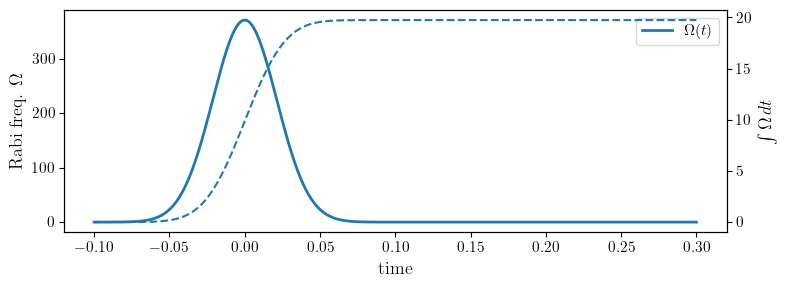

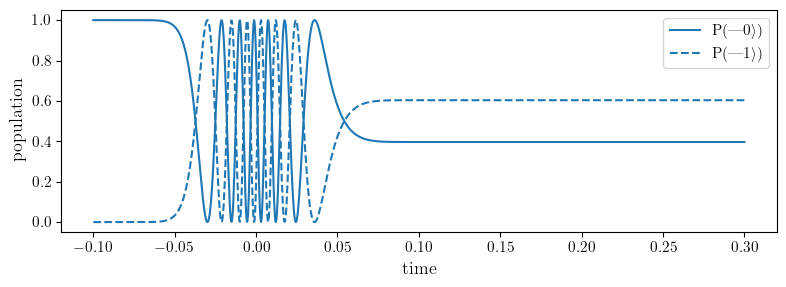

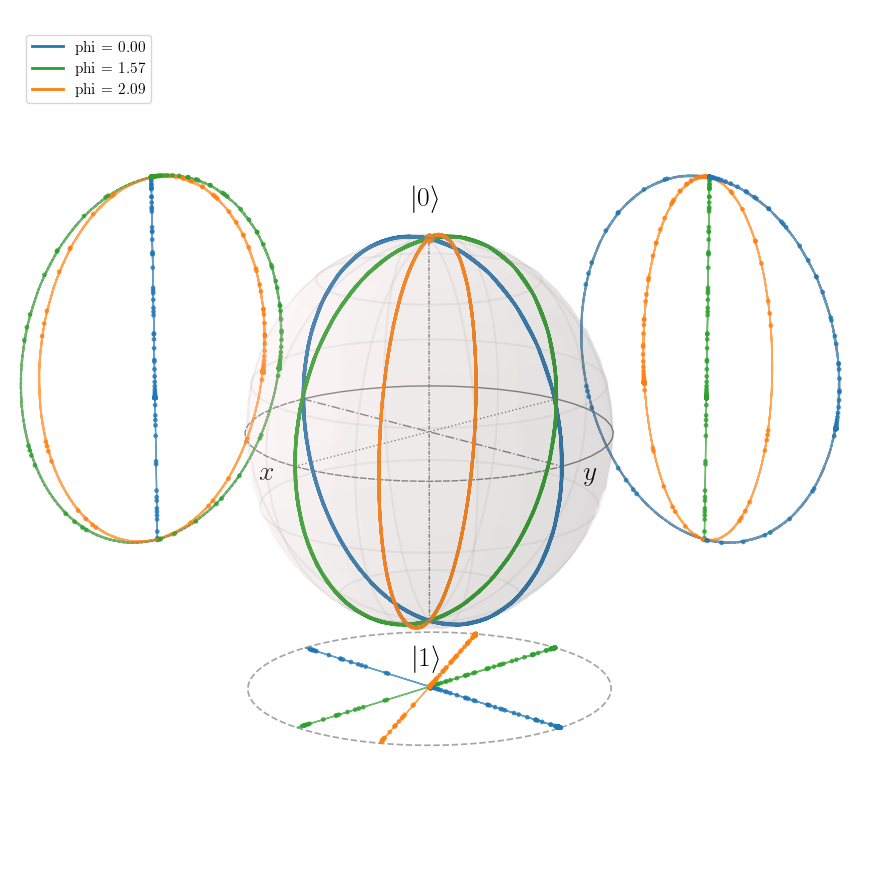

In [13]:
# Get envelope and compute scaling for pi pulse
field = epsilon_pulses(times, seq)
area_env = np.trapz(field, times)
print("Area of unscaled envelope: ", area_env)
# Phase selects rotation axis: 0 → x, np.pi/2 → y
phi_values = [0.0, np.pi/2, 2*np.pi/3]
all_states = []
psi0 = qt.basis(2, 0)               # |0>

for phi in phi_values:
    # ---------- build Ω(t) with Θ = 2π (for pi pulse) ----------
    sim_oqs.laser.pulse_phases = [phi]
    Omega_t = scaling * field
    Theta_check = np.trapz(Omega_t, times)                # should be 2π

    # ---------- evolution ----------
    result = qt.mesolve(scaling * qt.QobjEvo(sim_oqs.H_int_sl), psi0, times, options={"store_states": True})
    states = result.states
    all_states.append(states)

# ---------- diagnostics (for last phi) ----------
p1_final = pop_excited(states[-1])          # should be ~1 for φ=0 (x-π pulse)
print(f"Pulse area Θ = {Theta_check:.6f} (target 2π = {2*np.pi:.6f})")
print(f"Final excited-state population P(|1>) = {p1_final:.6f}")

# ---------- plots ----------
# 1) Rabi frequency and its area
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(times, Omega_t, lw=2, label=r'$\Omega(t)$')
ax.set_xlabel("time")
ax.set_ylabel(r'Rabi freq. $\Omega$')
ax.legend()
ax2 = ax.twinx()
ax2.plot(times, np.cumsum(np.concatenate([[0], 0.5*(Omega_t[1:]+Omega_t[:-1]) * np.diff(times)])),
         ls="--", label="cumulative area")
ax2.set_ylabel(r"$\int \Omega \, dt$")
fig.tight_layout()
plt.show()

# 2) Populations
P0 = [1 - pop_excited(s) for s in states]
P1 = [pop_excited(s) for s in states]
plt.figure(figsize=(8,3))
plt.plot(times, P0, label="P(|0⟩)")
plt.plot(times, P1, label="P(|1⟩)")
plt.xlabel("time")
plt.ylabel("population")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Bloch trajectory
labels = [f"phi = {phi:.2f}" for phi in phi_values]
plot_bloch_trajectories(all_states, labels=labels)

plt.show()